# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

In [2]:
pip install scipy==1.1.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import numpy as np
import os
from scipy import misc
#from scipy.misc.pilutil import imread, imresize
import datetime
from PIL import Image, ImageFilter, ImageEnhance
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

We set the random seed so that the results don't vary drastically.

In [5]:
import os
os.environ['PYTHONHASHSEED']="30"
np.random.seed(30)
import random as rn
rn.seed(30)
from scipy import stats
from keras import backend as K
import tensorflow as tf
tf.random.set_seed(30)

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [ ]:
#train_doc = np.random.permutation(open('/notebooks/storage/Final_data/Collated_training/train.csv').readlines())
#val_doc = np.random.permutation(open('/notebooks/storage/Final_data/Collated_training/val.csv').readlines())
#batch_size = #experiment with the batch size

In [7]:
# train and validatiaon data creator with ablation
# when ablation is 10, then 10 folders for each label will be selected.
def get_data(path, ablation=None):
    train_doc = np.random.permutation(open(path+'train.csv').readlines())
    val_doc = np.random.permutation(open(path+'val.csv').readlines())
    counts = np.zeros(5) # count for loading folders for 5 classes
    train_data = []
    val_data = []
    # when ablation is None pass full training and val data
    if ablation is not None:
        # iterating train doc
        for doc in train_doc:
            lable = int(doc.strip().split(';')[2])
            if counts[lable] < ablation:
                train_data.append(doc)
                counts[lable] += 1 
        counts = np.zeros(5)
        # iterating val doc
        for doc in val_doc:
            lable = int(doc.strip().split(';')[2])
            if counts[lable] < ablation:
                val_data.append(doc)
                counts[lable] += 1
    else:
        train_data, val_data = train_doc, val_doc
    return train_data, val_data

In [8]:
train_doc, val_doc = get_data('/content/drive/MyDrive/Gesture_Recognition_DataSet/', ablation=None)
batch_size = 32 # experiment with the batch size
enable_augmentation = False # augmentation of Data
# sequence ids
# selecting alternate frames from 7 to 26.
seq_idx = range(7,26,2)
# image dimensions
dim_x, dim_y = 120, 120

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [9]:
# generator with augmentation for train data
def generator(source_path, folder_list, batch_size, is_train = False, augmention = False, debug=False):
    # print('\nSource path = ', source_path, '; batch size =', batch_size)
    img_idx = seq_idx #create a list of image numbers you want to use for a particular video
    x = len(img_idx)
    y, z = dim_x, dim_y
    while True:
        # doubling the data for augmentation
        if is_train and augmention:
            t = np.concatenate((np.random.permutation(folder_list), np.random.permutation(folder_list)))
        else:
            t = np.random.permutation(folder_list)
            
        if (len(t)%batch_size) == 0:
            num_batches = int(len(t)/batch_size)
        else:
            num_batches = len(t)//batch_size + 1
            
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                if debug:
                    plt.figure(figsize=(20,5))
                #handling remaining datapoints
                folder_idx = folder + (batch*batch_size)
                if folder_idx >= len(t):
                    break
                folder_str = t[folder_idx]
                imgs = os.listdir(source_path+'/'+ folder_str.split(';')[0]) # read all the images in the folder
                # randomly enabling augmentation and augmentation type
                aug_type = None
                if is_train and augmention and rn.randint(0,1) == 1:
                    aug_type = rn.randint(0, 4) #randomly selecting augmentation type
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = misc.imread(source_path+'/'+ folder_str.strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)

                    # plotting original images for debugging purpose only
                    if debug:
                        plt.subplot(2, x, idx+1)
                        plt.imshow(image.astype('uint8'))

                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    # making the rectangle images into square by cropping sides
                    # so the aspect ration can be mantained while resizing.
                    if image.shape[1] > image.shape[0]:
                        diff_px = image.shape[1] - image.shape[0]
                        crop_start = diff_px//2
                        crop_end = crop_start + image.shape[0]
                        image = image[:, crop_start:crop_end]
                    elif image.shape[0] > image.shape[1]:
                        diff_px = image.shape[0] - image.shape[1]
                        crop_start = diff_px//2
                        crop_end = crop_start + image.shape[1]
                        image = image[:, crop_start:crop_end]

                    resized_im = misc.imresize(image, size=(y,z))

                    if aug_type is not None:
                        if aug_type == 0: # edge Enhancement
                            resized_im = np.array(Image.fromarray(resized_im, 'RGB').filter(ImageFilter.EDGE_ENHANCE))
                        elif aug_type == 1: # adding gaussian blur
                            resized_im = np.array(Image.fromarray(resized_im, 'RGB').filter(ImageFilter.GaussianBlur(1)))
                        elif aug_type == 2: # enchancing image detailing
                            resized_im = np.array(Image.fromarray(resized_im, 'RGB').filter(ImageFilter.DETAIL))
                        elif aug_type == 3: # sharpening image
                            resized_im = np.array(Image.fromarray(resized_im, 'RGB').filter(ImageFilter.SHARPEN))
                        elif aug_type == 4: # Brightness enhancement
                            resized_im = np.array(ImageEnhance.Brightness((Image.fromarray(resized_im, 'RGB'))).enhance(1.5))
                    # plotting rezised images for debugging purpose only
                    if debug:
                        plt.subplot(2, x, idx+x+1)
                        plt.imshow(resized_im)

                    batch_data[folder,idx,:,:,0] = resized_im[:,:,0]/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = resized_im[:,:,1]/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = resized_im[:,:,2]/255 #normalise and feed in the image

                batch_labels[folder, int(folder_str.strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do


Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [10]:
curr_dt_time = datetime.datetime.now()
train_path = '/content/drive/MyDrive/Gesture_Recognition_DataSet/train' #'/notebooks/storage/Final_data/Collated_training/train'
val_path =  '/content/drive/MyDrive/Gesture_Recognition_DataSet/val' #'/notebooks/storage/Final_data/Collated_training/val'

#multiply number train seq by 2 when using augmentation
multiplier = 1
if enable_augmentation:
    multiplier = 2
num_train_sequences = len(train_doc)*multiplier
print('# training sequences =', num_train_sequences)

num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)

num_epochs = 50 # choose the number of epochs
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 50


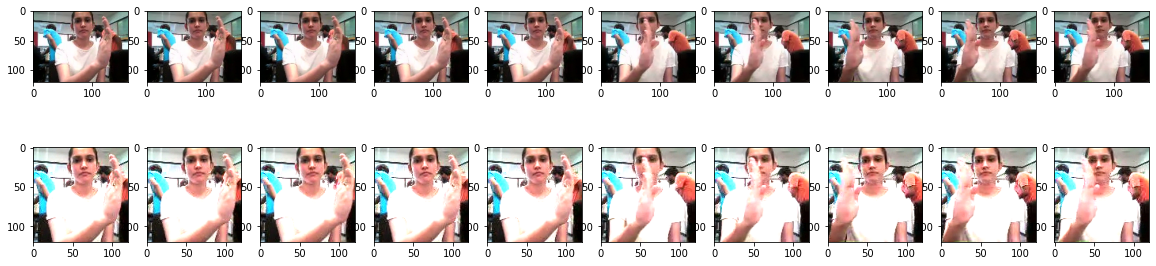

In [11]:
# testing generative 
test_gen = generator(train_path, train_doc, 1, is_train = True, augmention = True, debug = True)
d = next(test_gen)[0]

## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

In [12]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, ConvLSTM2D, GlobalAveragePooling2D, Dropout,GlobalAveragePooling3D
from keras.layers.convolutional import Conv2D, Conv3D, MaxPooling3D, MaxPooling2D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers

#write your model here
#input shape for the st layer
input_shape = (len(seq_idx), dim_x, dim_y, 3)
np.random.seed(30)

Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

### Experiment - 1 & 2 (Conv3D)

In [ ]:
model = Sequential()
model.add(Conv3D(32, kernel_size=3, activation='relu', input_shape=input_shape))
model.add(MaxPooling3D(pool_size=2))

model.add(Conv3D(64, kernel_size=3, activation='relu'))
model.add(MaxPooling3D(pool_size=2))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(5, activation='softmax'))

optimiser = tf.keras.optimizers.Adam() #write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 8, 118, 118, 32)   2624      
                                                                 
 max_pooling3d (MaxPooling3D  (None, 4, 59, 59, 32)    0         
 )                                                               
                                                                 
 conv3d_1 (Conv3D)           (None, 2, 57, 57, 64)     55360     
                                                                 
 max_pooling3d_1 (MaxPooling  (None, 1, 28, 28, 64)    0         
 3D)                                                             
                                                                 
 flatten (Flatten)           (None, 50176)             0         
                                                                 
 dense_3 (Dense)             (None, 256)              

In [ ]:
# Train Model
train_generator = generator(train_path, train_doc, batch_size = 40, is_train = True, augmention = enable_augmentation)
val_generator = generator(val_path, val_doc, batch_size=40)

model_name = 'model_init_exp1' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'

if not os.path.exists(model_name):
    os.mkdir(model_name)

filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001, verbose=1) # write the REducelronplateau code here

callbacks_list = [checkpoint, LR]

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1
	
history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=15, verbose=1, 
                        callbacks=callbacks_list, validation_data=val_generator, 
                        validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/15
21/21 [==============================] - ETA: 0s - loss: 1.9148 - categorical_accuracy: 0.2202
Epoch 1: saving model to model_init_exp1_2022-09-1110_14_38.722627/model-00001-1.91483-0.22024-1.28564-0.33125.h5
21/21 [==============================] - 225s 11s/step - loss: 1.9148 - categorical_accuracy: 0.2202 - val_loss: 1.2856 - val_categorical_accuracy: 0.3313 - lr: 0.0010
Epoch 2/15
21/21 [==============================] - ETA: 0s - loss: 1.2654 - categorical_accuracy: 0.4560
Epoch 2: saving model to model_init_exp1_2022-09-1110_14_38.722627/model-00002-1.26538-0.45595-0.84144-0.43750.h5
21/21 [==============================] - 217s 10s/step - loss: 1.2654 - categorical_accuracy: 0.4560 - val_loss: 0.8414 - val_categorical_accuracy: 0.4375 - lr: 0.0010
Epoch 3/15
21/21 [==============================] - ETA: 0s - loss: 0.7312 - categorical_accuracy: 0.7071
Epoch 3: saving model to model_init_exp1_2022-09-1110_14_38.722627/model-00003-0.73118-0.70714-1.02930-0.51250.h5
21/2

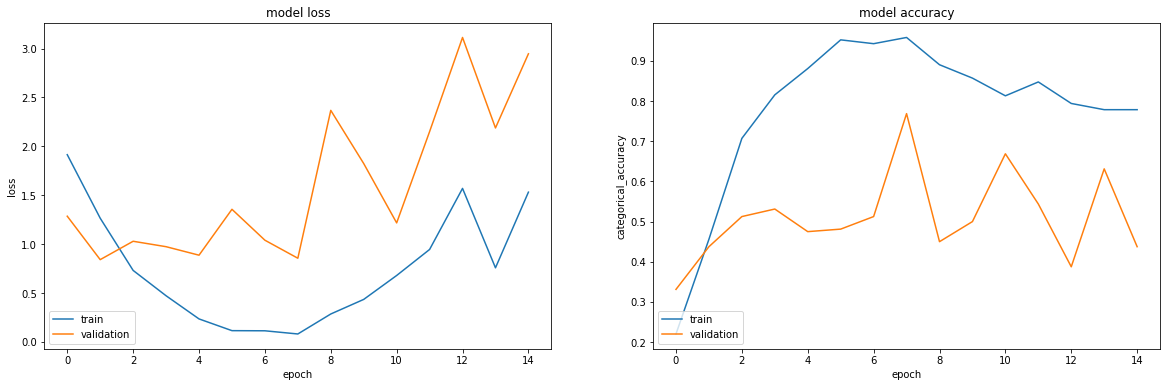

In [ ]:
plt.figure(figsize=(20,6))
ax1 = plt.subplot(121)
ax1 = plt.plot(history.history['loss'])
ax1 = plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower left')
ax2 = plt.subplot(122)
ax2 = plt.plot(history.history['categorical_accuracy'])
ax2 = plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('categorical_accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower left')

### Experiment - 3 (Conv3D)

In [ ]:
model = Sequential()

model.add(Conv3D(32, kernel_size=3, activation='relu', input_shape=input_shape))
model.add(Conv3D(64, kernel_size=3, activation='relu'))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(128, kernel_size=3, activation='relu'))
model.add(MaxPooling3D(pool_size=(1, 2, 2)))

model.add(Conv3D(256, kernel_size=(1, 3, 3), activation='relu'))
model.add(MaxPooling3D(pool_size=(1, 2, 2)))

model.add(Conv3D(512, kernel_size=(1, 3, 3), activation='relu'))
model.add(Conv3D(512, kernel_size=(1, 3, 3), activation='relu'))
model.add(MaxPooling3D(pool_size=(1, 2, 2)))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(5, activation='softmax'))

optimiser = tf.keras.optimizers.Adam(lr=0.01) #write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model.summary())

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_60 (Conv3D)          (None, 8, 118, 118, 32)   2624      
                                                                 
 conv3d_61 (Conv3D)          (None, 6, 116, 116, 64)   55360     
                                                                 
 max_pooling3d_37 (MaxPoolin  (None, 3, 58, 58, 64)    0         
 g3D)                                                            
                                                                 
 conv3d_62 (Conv3D)          (None, 1, 56, 56, 128)    221312    
                                                                 
 max_pooling3d_38 (MaxPoolin  (None, 1, 28, 28, 128)   0         
 g3D)                                                            
                                                                 
 conv3d_63 (Conv3D)          (None, 1, 26, 26, 256)  

In [ ]:
# Train Model
train_generator = generator(train_path, train_doc, batch_size = 30, is_train = True, augmention = enable_augmentation)
val_generator = generator(val_path, val_doc, batch_size=30)

model_name = 'model_init_exp3' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'

if not os.path.exists(model_name):
    os.mkdir(model_name)

filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001, verbose=1) # write the REducelronplateau code here

callbacks_list = [checkpoint, LR]

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1
	
history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=25, verbose=1, 
                        callbacks=callbacks_list, validation_data=val_generator, 
                        validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

### Experiment - 4 (Conv3D)

In [ ]:
model = Sequential()

model.add(Conv3D(32, kernel_size=3, activation='relu', input_shape=input_shape))
model.add(Conv3D(64, kernel_size=3, activation='relu'))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(128, kernel_size=3, activation='relu'))
model.add(MaxPooling3D(pool_size=(1, 2, 2)))

model.add(Conv3D(256, kernel_size=(1, 3, 3), activation='relu'))
model.add(MaxPooling3D(pool_size=(1, 2, 2)))

model.add(Conv3D(512, kernel_size=(1, 3, 3), activation='relu'))
model.add(Conv3D(512, kernel_size=(1, 3, 3), activation='relu'))
model.add(MaxPooling3D(pool_size=(1, 2, 2)))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(5, activation='softmax'))

optimiser = tf.keras.optimizers.Adam(lr=0.01) #write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_10 (Conv3D)          (None, 8, 118, 118, 32)   2624      
                                                                 
 conv3d_11 (Conv3D)          (None, 6, 116, 116, 64)   55360     
                                                                 
 max_pooling3d_6 (MaxPooling  (None, 3, 58, 58, 64)    0         
 3D)                                                             
                                                                 
 conv3d_12 (Conv3D)          (None, 1, 56, 56, 128)    221312    
                                                                 
 max_pooling3d_7 (MaxPooling  (None, 1, 28, 28, 128)   0         
 3D)                                                             
                                                                 
 conv3d_13 (Conv3D)          (None, 1, 26, 26, 256)   

In [ ]:
# Train Model
train_generator = generator(train_path, train_doc, batch_size = 20, is_train = True, augmention = enable_augmentation)
val_generator = generator(val_path, val_doc, batch_size=20)

model_name = 'model_init_exp4' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'

if not os.path.exists(model_name):
    os.mkdir(model_name)

filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001, verbose=1) # write the REducelronplateau code here

callbacks_list = [checkpoint, LR]

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1
	
history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=25, verbose=1, 
                        callbacks=callbacks_list, validation_data=val_generator, 
                        validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/25
21/21 [==============================] - ETA: 0s - loss: 6088.0117 - categorical_accuracy: 0.1857 
Epoch 1: saving model to model_init_exp4_2022-09-1204_49_10.637073/model-00001-6088.01172-0.18571-1.72901-0.23750.h5
21/21 [==============================] - 1354s 66s/step - loss: 6088.0117 - categorical_accuracy: 0.1857 - val_loss: 1.7290 - val_categorical_accuracy: 0.2375 - lr: 0.0100
Epoch 2/25
21/21 [==============================] - ETA: 0s - loss: 1.6005 - categorical_accuracy: 0.1762 
Epoch 2: saving model to model_init_exp4_2022-09-1204_49_10.637073/model-00002-1.60046-0.17619-1.61090-0.17500.h5
21/21 [==============================] - 821s 40s/step - loss: 1.6005 - categorical_accuracy: 0.1762 - val_loss: 1.6109 - val_categorical_accuracy: 0.1750 - lr: 0.0100
Epoch 3/25
21/21 [==============================] - ETA: 0s - loss: 1.6108 - categorical_accuracy: 0.1905 
Epoch 3: saving model to model_init_exp4_2022-09-1204_49_10.637073/model-00003-1.61083-0.19048-1.61247-0.

### Experiment - 5 & 6 (Conv3D)

In [ ]:
model = Sequential()

model.add(Conv3D(32, kernel_size=3, activation='relu', input_shape=input_shape))
model.add(Conv3D(64, kernel_size=3, activation='relu'))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(BatchNormalization())

model.add(Conv3D(128, kernel_size=3, activation='relu'))
model.add(MaxPooling3D(pool_size=(1, 2, 2)))
model.add(BatchNormalization())

model.add(Conv3D(256, kernel_size=(1, 3, 3), activation='relu'))
model.add(MaxPooling3D(pool_size=(1, 2, 2)))
model.add(BatchNormalization())

model.add(Conv3D(512, kernel_size=(1, 3, 3), activation='relu'))
model.add(Conv3D(512, kernel_size=(1, 3, 3), activation='relu'))
model.add(MaxPooling3D(pool_size=(1, 2, 2)))
model.add(BatchNormalization())

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(5, activation='softmax'))

optimiser = tf.keras.optimizers.Adam(lr=0.0002) #write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model.summary())

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_22 (Conv3D)          (None, 8, 118, 118, 32)   2624      
                                                                 
 conv3d_23 (Conv3D)          (None, 6, 116, 116, 64)   55360     
                                                                 
 max_pooling3d_14 (MaxPoolin  (None, 3, 58, 58, 64)    0         
 g3D)                                                            
                                                                 
 batch_normalization_5 (Batc  (None, 3, 58, 58, 64)    256       
 hNormalization)                                                 
                                                                 
 conv3d_24 (Conv3D)          (None, 1, 56, 56, 128)    221312    
                                                                 
 max_pooling3d_15 (MaxPoolin  (None, 1, 28, 28, 128)  

In [ ]:
# Train Model
train_generator = generator(train_path, train_doc, batch_size = 20, is_train = True, augmention = enable_augmentation)
val_generator = generator(val_path, val_doc, batch_size=20)

model_name = 'model_init_exp5' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'

if not os.path.exists(model_name):
    os.mkdir(model_name)

filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001, verbose=1) # write the REducelronplateau code here

callbacks_list = [checkpoint, LR]

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1
	
history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=15, verbose=1, 
                        callbacks=callbacks_list, validation_data=val_generator, 
                        validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/15
21/21 [==============================] - ETA: 0s - loss: 1.7962 - categorical_accuracy: 0.4905 
Epoch 1: saving model to model_init_exp5_2022-09-1204_49_10.637073/model-00001-1.79623-0.49048-1.75613-0.20000.h5
21/21 [==============================] - 702s 33s/step - loss: 1.7962 - categorical_accuracy: 0.4905 - val_loss: 1.7561 - val_categorical_accuracy: 0.2000 - lr: 2.0000e-04
Epoch 2/15
21/21 [==============================] - ETA: 0s - loss: 1.1606 - categorical_accuracy: 0.6167 
Epoch 2: saving model to model_init_exp5_2022-09-1204_49_10.637073/model-00002-1.16064-0.61667-1.89648-0.21250.h5
21/21 [==============================] - 686s 33s/step - loss: 1.1606 - categorical_accuracy: 0.6167 - val_loss: 1.8965 - val_categorical_accuracy: 0.2125 - lr: 2.0000e-04
Epoch 3/15
21/21 [==============================] - ETA: 0s - loss: 0.6534 - categorical_accuracy: 0.7714 
Epoch 3: saving model to model_init_exp5_2022-09-1204_49_10.637073/model-00003-0.65339-0.77143-2.32889-0.16

### Experiment - 7 & 8 (Conv3D)

In [ ]:
model = Sequential()

model.add(Conv3D(32, kernel_size=3, activation='relu', input_shape=input_shape))
model.add(Conv3D(64, kernel_size=3, activation='relu'))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(BatchNormalization())
#model.add(Dropout(0.2))
model.add(Dropout(0.5))

model.add(Conv3D(128, kernel_size=3, activation='relu'))
model.add(MaxPooling3D(pool_size=(1, 2, 2)))
model.add(BatchNormalization())
#model.add(Dropout(0.2))
model.add(Dropout(0.5))

model.add(Conv3D(256, kernel_size=(1, 3, 3), activation='relu'))
model.add(MaxPooling3D(pool_size=(1, 2, 2)))
model.add(BatchNormalization())
#model.add(Dropout(0.2))
model.add(Dropout(0.5))

model.add(Conv3D(512, kernel_size=(1, 3, 3), activation='relu'))
model.add(Conv3D(512, kernel_size=(1, 3, 3), activation='relu'))
model.add(MaxPooling3D(pool_size=(1, 2, 2)))
model.add(BatchNormalization())
#model.add(Dropout(0.2))
model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(5, activation='softmax'))

optimiser = tf.keras.optimizers.Adam(lr=0.01) #write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model.summary())

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_16 (Conv3D)          (None, 8, 118, 118, 32)   2624      
                                                                 
 conv3d_17 (Conv3D)          (None, 6, 116, 116, 64)   55360     
                                                                 
 max_pooling3d_10 (MaxPoolin  (None, 3, 58, 58, 64)    0         
 g3D)                                                            
                                                                 
 batch_normalization (BatchN  (None, 3, 58, 58, 64)    256       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 3, 58, 58, 64)     0         
                                                                 
 conv3d_18 (Conv3D)          (None, 1, 56, 56, 128)   

In [ ]:
# Train Model
train_generator = generator(train_path, train_doc, batch_size = 20, is_train = True, augmention = enable_augmentation)
val_generator = generator(val_path, val_doc, batch_size=20)

model_name = 'model_init_exp6' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'

if not os.path.exists(model_name):
    os.mkdir(model_name)

filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001, verbose=1) # write the REducelronplateau code here

callbacks_list = [checkpoint, LR]

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1
	
history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=15, verbose=1, 
                        callbacks=callbacks_list, validation_data=val_generator, 
                        validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/15
21/21 [==============================] - ETA: 0s - loss: 3.3198 - categorical_accuracy: 0.2571 
Epoch 1: saving model to model_init_exp6_2022-09-1204_49_10.637073/model-00001-3.31977-0.25714-1712.88904-0.18750.h5
21/21 [==============================] - 733s 35s/step - loss: 3.3198 - categorical_accuracy: 0.2571 - val_loss: 1712.8890 - val_categorical_accuracy: 0.1875 - lr: 0.0100
Epoch 2/15
21/21 [==============================] - ETA: 0s - loss: 1.7545 - categorical_accuracy: 0.3690 
Epoch 2: saving model to model_init_exp6_2022-09-1204_49_10.637073/model-00002-1.75447-0.36905-269.87042-0.22500.h5
21/21 [==============================] - 721s 34s/step - loss: 1.7545 - categorical_accuracy: 0.3690 - val_loss: 269.8704 - val_categorical_accuracy: 0.2250 - lr: 0.0100
Epoch 3/15
21/21 [==============================] - ETA: 0s - loss: 1.5885 - categorical_accuracy: 0.4262 
Epoch 3: saving model to model_init_exp6_2022-09-1204_49_10.637073/model-00003-1.58853-0.42619-103.67554-

### Experiment - 9 (Conv3D)

In [ ]:
model = Sequential()

model.add(Conv3D(32, kernel_size=3, activation='relu', input_shape=input_shape))
model.add(Conv3D(64, kernel_size=3, activation='relu'))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Conv3D(128, kernel_size=3, activation='relu'))
model.add(MaxPooling3D(pool_size=(1, 2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Conv3D(256, kernel_size=(1, 3, 3), activation='relu'))
model.add(MaxPooling3D(pool_size=(1, 2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(5, activation='softmax'))

optimiser = tf.keras.optimizers.Adam(lr=0.01) #write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model.summary())

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_28 (Conv3D)          (None, 8, 118, 118, 32)   2624      
                                                                 
 conv3d_29 (Conv3D)          (None, 6, 116, 116, 64)   55360     
                                                                 
 max_pooling3d_18 (MaxPoolin  (None, 3, 58, 58, 64)    0         
 g3D)                                                            
                                                                 
 batch_normalization_10 (Bat  (None, 3, 58, 58, 64)    256       
 chNormalization)                                                
                                                                 
 dropout_4 (Dropout)         (None, 3, 58, 58, 64)     0         
                                                                 
 conv3d_30 (Conv3D)          (None, 1, 56, 56, 128)   

In [ ]:
# Train Model
train_generator = generator(train_path, train_doc, batch_size = 20, is_train = True, augmention = enable_augmentation)
val_generator = generator(val_path, val_doc, batch_size=20)

model_name = 'model_init_exp7' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'

if not os.path.exists(model_name):
    os.mkdir(model_name)

filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001, verbose=1) # write the REducelronplateau code here

callbacks_list = [checkpoint, LR]

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1
	
history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=20, verbose=1, 
                        callbacks=callbacks_list, validation_data=val_generator, 
                        validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

### Experiment - 10 (Conv3D)

In [ ]:
## loss: 0.1388 - categorical_accuracy: 0.9539 - val_loss: 0.1661 - val_categorical_accuracy: 0.9297

model = Sequential()

model.add(Conv3D(32, kernel_size=3, activation='relu', input_shape=input_shape))
model.add(Conv3D(64, kernel_size=3, activation='relu'))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Conv3D(128, kernel_size=3, activation='relu'))
model.add(MaxPooling3D(pool_size=(1, 2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Conv3D(256, kernel_size=(1, 3, 3), activation='relu'))
model.add(MaxPooling3D(pool_size=(1, 2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(GlobalAveragePooling3D())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(5, activation='softmax'))

optimiser = tf.keras.optimizers.Adam(lr=0.01) #write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model.summary())

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_32 (Conv3D)          (None, 8, 118, 118, 32)   2624      
                                                                 
 conv3d_33 (Conv3D)          (None, 6, 116, 116, 64)   55360     
                                                                 
 max_pooling3d_21 (MaxPoolin  (None, 3, 58, 58, 64)    0         
 g3D)                                                            
                                                                 
 batch_normalization_14 (Bat  (None, 3, 58, 58, 64)    256       
 chNormalization)                                                
                                                                 
 dropout_7 (Dropout)         (None, 3, 58, 58, 64)     0         
                                                                 
 conv3d_34 (Conv3D)          (None, 1, 56, 56, 128)   

In [ ]:
# Train Model
train_generator = generator(train_path, train_doc, batch_size = 20, is_train = True, augmention = enable_augmentation)
val_generator = generator(val_path, val_doc, batch_size=20)

model_name = 'model_init_exp8' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'

if not os.path.exists(model_name):
    os.mkdir(model_name)

filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001, verbose=1) # write the REducelronplateau code here

callbacks_list = [checkpoint, LR]

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1
	
history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=15, verbose=1, 
                        callbacks=callbacks_list, validation_data=val_generator, 
                        validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

### Experiment - 11 (TimeDistributed Conv2D + GRU)

In [ ]:
model = Sequential()
model.add(TimeDistributed(
    Conv2D(32, (3,3), activation='relu'), input_shape=input_shape)
)
model.add(TimeDistributed(
    MaxPooling2D((2,2)))
)
model.add(BatchNormalization())

model.add(TimeDistributed(
    Conv2D(64, (3,3), activation='relu'))
)
model.add(TimeDistributed(
    MaxPooling2D((2,2)))
)
model.add(BatchNormalization())

model.add(TimeDistributed(GlobalAveragePooling2D()))
model.add(TimeDistributed(Dense(64, activation='relu')))
model.add(BatchNormalization())

model.add(GRU(128))
model.add(BatchNormalization())
model.add(Dense(5, activation='softmax'))

optimiser = tf.keras.optimizers.Adam(lr=0.01) #write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model.summary())

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 10, 118, 118, 32)  896      
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 10, 59, 59, 32)   0         
 tributed)                                                       
                                                                 
 batch_normalization_18 (Bat  (None, 10, 59, 59, 32)   128       
 chNormalization)                                                
                                                                 
 time_distributed_2 (TimeDis  (None, 10, 57, 57, 64)   18496     
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 10, 28, 28, 64)  

In [ ]:
# Train Model
train_generator = generator(train_path, train_doc, batch_size = 20, is_train = True, augmention = enable_augmentation)
val_generator = generator(val_path, val_doc, batch_size=20)

model_name = 'model_init_exp9' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'

if not os.path.exists(model_name):
    os.mkdir(model_name)

filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001, verbose=1) # write the REducelronplateau code here

callbacks_list = [checkpoint, LR]

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1
	
history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=20, verbose=1, 
                        callbacks=callbacks_list, validation_data=val_generator, 
                        validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

### Experiment - 12 (TimeDistributed Conv2D + GRU)

In [ ]:
model = Sequential()
model.add(TimeDistributed(
    Conv2D(32, (3,3), activation='relu'), input_shape=input_shape)
)
model.add(TimeDistributed(
    MaxPooling2D((2,2)))
)
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(TimeDistributed(
    Conv2D(64, (3,3), activation='relu'))
)
model.add(TimeDistributed(
    MaxPooling2D((2,2)))
)
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(TimeDistributed(GlobalAveragePooling2D()))
model.add(TimeDistributed(Dense(64, activation='relu')))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(GRU(128))
model.add(BatchNormalization())
model.add(Dense(5, activation='softmax'))

optimiser = tf.keras.optimizers.Adam(lr=0.01) #write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model.summary())

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_6 (TimeDis  (None, 10, 118, 118, 32)  896      
 tributed)                                                       
                                                                 
 time_distributed_7 (TimeDis  (None, 10, 59, 59, 32)   0         
 tributed)                                                       
                                                                 
 batch_normalization_22 (Bat  (None, 10, 59, 59, 32)   128       
 chNormalization)                                                
                                                                 
 dropout_10 (Dropout)        (None, 10, 59, 59, 32)    0         
                                                                 
 time_distributed_8 (TimeDis  (None, 10, 57, 57, 64)   18496     
 tributed)                                            

In [ ]:
# Train Model
train_generator = generator(train_path, train_doc, batch_size = 30, is_train = True, augmention = enable_augmentation)
val_generator = generator(val_path, val_doc, batch_size=30)

model_name = 'model_init_exp10' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'

if not os.path.exists(model_name):
    os.mkdir(model_name)

filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001, verbose=1) # write the REducelronplateau code here

callbacks_list = [checkpoint, LR]

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1
	
history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=25, verbose=1, 
                        callbacks=callbacks_list, validation_data=val_generator, 
                        validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

### Experiment - 13 (TimeDistributed Conv2D + Dense)

In [ ]:
model = Sequential()
model.add(TimeDistributed(
    Conv2D(32, (3,3), activation='relu'), input_shape=input_shape)
)
model.add(TimeDistributed(
    MaxPooling2D((2,2)))
)
model.add(BatchNormalization())

model.add(TimeDistributed(
    Conv2D(64, (3,3), activation='relu'))
)
model.add(TimeDistributed(
    MaxPooling2D((2,2)))
)
model.add(BatchNormalization())

model.add(TimeDistributed(
    Conv2D(128, (3,3), activation='relu'))
)
model.add(TimeDistributed(
    MaxPooling2D((2,2)))
)
model.add(BatchNormalization())

model.add(GlobalAveragePooling3D())
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(5, activation='softmax'))

optimiser = tf.keras.optimizers.Adam(lr=0.01) #write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model.summary())

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_12 (TimeDi  (None, 10, 118, 118, 32)  896      
 stributed)                                                      
                                                                 
 time_distributed_13 (TimeDi  (None, 10, 59, 59, 32)   0         
 stributed)                                                      
                                                                 
 batch_normalization_26 (Bat  (None, 10, 59, 59, 32)   128       
 chNormalization)                                                
                                                                 
 time_distributed_14 (TimeDi  (None, 10, 57, 57, 64)   18496     
 stributed)                                                      
                                                                 
 time_distributed_15 (TimeDi  (None, 10, 28, 28, 64) 

In [ ]:
# Train Model
train_generator = generator(train_path, train_doc, batch_size = 20, is_train = True, augmention = enable_augmentation)
val_generator = generator(val_path, val_doc, batch_size=20)

model_name = 'model_init_exp11' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'

if not os.path.exists(model_name):
    os.mkdir(model_name)

filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001, verbose=1) # write the REducelronplateau code here

callbacks_list = [checkpoint, LR]

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1
	
history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=25, verbose=1, 
                        callbacks=callbacks_list, validation_data=val_generator, 
                        validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

### Experiment - 14 (TimeDistributed + Conv2D + LSTM)

In [ ]:
model = Sequential()
model.add(TimeDistributed(
    Conv2D(8, (3,3), activation='relu'), input_shape=input_shape)
)
model.add(BatchNormalization())
model.add(TimeDistributed(
    Conv2D(16, (3,3), activation='relu'))
)
model.add(BatchNormalization())
model.add(
    ConvLSTM2D(8, kernel_size = 3, return_sequences=False)
)
model.add(BatchNormalization())
model.add(TimeDistributed(
    Dense(64, activation='relu'))
)
model.add(BatchNormalization())
model.add(GlobalAveragePooling2D())
model.add(Dense(64, activation='relu'))
model.add(Dense(5, activation='softmax'))

optimiser = tf.keras.optimizers.Adam(lr=0.01) #write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model.summary())

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_21 (TimeDi  (None, 10, 118, 118, 8)  224       
 stributed)                                                      
                                                                 
 batch_normalization_34 (Bat  (None, 10, 118, 118, 8)  32        
 chNormalization)                                                
                                                                 
 time_distributed_22 (TimeDi  (None, 10, 116, 116, 16)  1168     
 stributed)                                                      
                                                                 
 batch_normalization_35 (Bat  (None, 10, 116, 116, 16)  64       
 chNormalization)                                                
                                                                 
 conv_lstm2d_1 (ConvLSTM2D)  (None, 114, 114, 8)     

In [ ]:
# Train Model
train_generator = generator(train_path, train_doc, batch_size = 20, is_train = True, augmention = enable_augmentation)
val_generator = generator(val_path, val_doc, batch_size=20)

model_name = 'model_init_exp12' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'

if not os.path.exists(model_name):
    os.mkdir(model_name)

filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001, verbose=1) # write the REducelronplateau code here

callbacks_list = [checkpoint, LR]

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1
	
history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=15, verbose=1, 
                        callbacks=callbacks_list, validation_data=val_generator, 
                        validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

## Final Model

In [ ]:
model = Sequential()
model.add(TimeDistributed(
    Conv2D(8, (3,3), activation='relu'), input_shape=input_shape)
)
model.add(BatchNormalization())
model.add(TimeDistributed(
    Conv2D(16, (3,3), activation='relu'))
)
model.add(BatchNormalization())
model.add(
    ConvLSTM2D(8, kernel_size = 3, return_sequences=False)
)
model.add(BatchNormalization())
model.add(TimeDistributed(
    Dense(64, activation='relu'))
)
model.add(BatchNormalization())
model.add(GlobalAveragePooling2D())
model.add(Dense(64, activation='relu'))
model.add(Dense(5, activation='softmax'))

In [ ]:
optimiser = tf.keras.optimizers.Adam(lr=0.01) #write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 10, 118, 118, 8)  224       
 ibuted)                                                         
                                                                 
 batch_normalization (BatchN  (None, 10, 118, 118, 8)  32        
 ormalization)                                                   
                                                                 
 time_distributed_1 (TimeDis  (None, 10, 116, 116, 16)  1168     
 tributed)                                                       
                                                                 
 batch_normalization_1 (Batc  (None, 10, 116, 116, 16)  64       
 hNormalization)                                                 
                                                                 
 conv_lstm2d (ConvLSTM2D)    (None, 114, 114, 8)       6

In [ ]:
#optimiser = #write your optimizer
#model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
#print (model.summary())

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [ ]:
train_generator = generator(train_path, train_doc, batch_size, is_train = True, augmention = enable_augmentation)
val_generator = generator(val_path, val_doc, batch_size)

In [ ]:
model_name = 'model_init_exp_16' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'

if not os.path.exists(model_name):
    os.mkdir(model_name)

filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001, verbose=1) # write the REducelronplateau code here

callbacks_list = [checkpoint, LR]

The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

In [ ]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [ ]:
history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                        callbacks=callbacks_list, validation_data=val_generator, 
                        validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/50
21/21 [==============================] - ETA: 0s - loss: 1.1601 - categorical_accuracy: 0.4509 
Epoch 1: saving model to model_init_exp_16_2022-09-1110_14_38.722627/model-00001-1.16008-0.45089-1.26954-0.17969.h5
21/21 [==============================] - 373s 18s/step - loss: 1.1601 - categorical_accuracy: 0.4509 - val_loss: 1.2695 - val_categorical_accuracy: 0.1797 - lr: 0.0100
Epoch 2/50
21/21 [==============================] - ETA: 0s - loss: 1.0260 - categorical_accuracy: 0.5179 
Epoch 2: saving model to model_init_exp_16_2022-09-1110_14_38.722627/model-00002-1.02600-0.51786-1.30938-0.21094.h5
21/21 [==============================] - 377s 18s/step - loss: 1.0260 - categorical_accuracy: 0.5179 - val_loss: 1.3094 - val_categorical_accuracy: 0.2109 - lr: 0.0100
Epoch 3/50
21/21 [==============================] - ETA: 0s - loss: 1.0099 - categorical_accuracy: 0.5744 
Epoch 3: saving model to model_init_exp_16_2022-09-1110_14_38.722627/model-00003-1.00987-0.57440-1.29306-0.2187

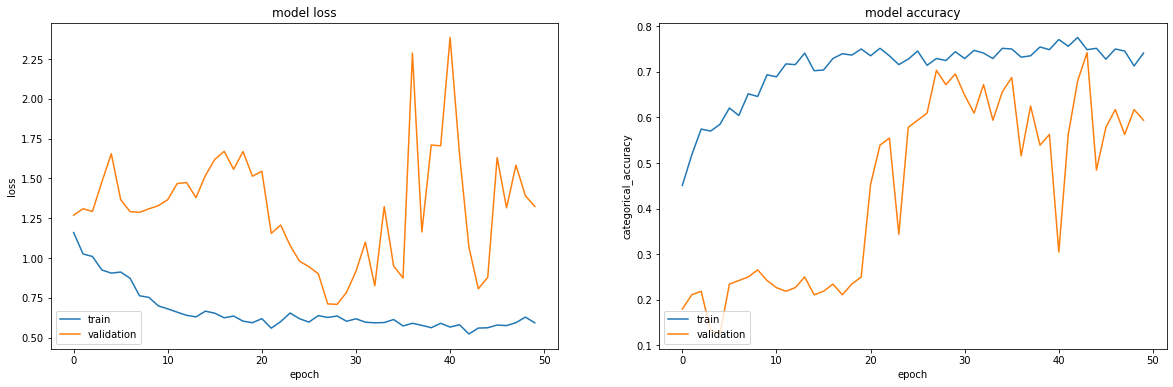

In [ ]:
plt.figure(figsize=(20,6))
ax1 = plt.subplot(121)
ax1 = plt.plot(history.history['loss'])
ax1 = plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower left')
ax2 = plt.subplot(122)
ax2 = plt.plot(history.history['categorical_accuracy'])
ax2 = plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('categorical_accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower left')